### Imports

In [1]:
# various imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# setting Seaborn display pattern for matplotlib
sns.set()

# sklearn for preprocessing and model evaluation
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# faster data loading
import shutil
import os

# model-related imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import (
    GlobalAveragePooling2D, Lambda, Dense, BatchNormalization, Activation,
    Dropout, Concatenate
)

# mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Manipulating the DataFrame

In [2]:
imageDataframe = pd.read_csv('/content/drive/MyDrive/Deep Learing Project/delivery/processed_image_data_final.csv')

# encode the column of the tumor class - binary => LabelEncoder
classEncoder = LabelEncoder()
imageDataframe['Benign or Malignant'] = classEncoder.fit_transform(imageDataframe['Benign or Malignant'])

counts = imageDataframe['Benign or Malignant'].value_counts()

# encode the column of the tumor subclass - multi-class => OneHotEncoder
subClassEncoder= OneHotEncoder(sparse_output = False)
imageDataframe[subClassEncoder.get_feature_names_out(['Cancer Type'])] = subClassEncoder.fit_transform(imageDataframe[['Cancer Type']])

# drop magnification column
imageDataframe.drop(columns=['Cancer Type', 'Magnification'], inplace = True)

imageDataframe.sample(10)

,path_to_image,Benign or Malignant,file_name,rel_path,Cancer Type_Adenosis,Cancer Type_Ductal Carcinoma,Cancer Type_Fibroadenoma,Cancer Type_Lobular Carcinoma,Cancer Type_Mucinous Carcinoma,Cancer Type_Papillary Carcinoma,Cancer Type_Phyllodes Tumor,Cancer Type_Tubular Adenoma
7399,BreaKHis_v1/histology_slides/breast/malignant/...,1,SOB_M_LC-14-13412-400-015.png,/tmp/SOB_M_LC-14-13412-400-015.png,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
7322,BreaKHis_v1/histology_slides/breast/malignant/...,1,SOB_M_LC-14-16196-40-003.png,/tmp/SOB_M_LC-14-16196-40-003.png,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2445,BreaKHis_v1/histology_slides/breast/benign/SOB...,0,SOB_B_PT-14-29315EF-400-007.png,/tmp/SOB_B_PT-14-29315EF-400-007.png,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6367,BreaKHis_v1/histology_slides/breast/malignant/...,1,SOB_M_DC-14-13993-40-032.png,/tmp/SOB_M_DC-14-13993-40-032.png,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2539,BreaKHis_v1/histology_slides/breast/malignant/...,1,SOB_M_MC-14-16456-100-006.png,/tmp/SOB_M_MC-14-16456-100-006.png,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1624,BreaKHis_v1/histology_slides/breast/benign/SOB...,0,SOB_B_F-14-25197-100-027.png,/tmp/SOB_B_F-14-25197-100-027.png,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1120,BreaKHis_v1/histology_slides/breast/benign/SOB...,0,SOB_B_F-14-23222AB-40-011.png,/tmp/SOB_B_F-14-23222AB-40-011.png,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
7597,BreaKHis_v1/histology_slides/breast/malignant/...,1,SOB_M_LC-14-15570-40-033.png,/tmp/SOB_M_LC-14-15570-40-033.png,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1365,BreaKHis_v1/histology_slides/breast/benign/SOB...,0,SOB_B_F-14-9133-40-016.png,/tmp/SOB_B_F-14-9133-40-016.png,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2731,BreaKHis_v1/histology_slides/breast/malignant/...,1,SOB_M_MC-14-12773-100-007.png,/tmp/SOB_M_MC-14-12773-100-007.png,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [3]:
# check for class counts
imageDataframe.value_counts('Benign or Malignant')

,count
Benign or Malignant,
1,5429
0,2480


In [4]:
imageDataframe = imageDataframe[['rel_path', 'Benign or Malignant']]

file_paths = imageDataframe.copy()
file_paths.sample(10)

,rel_path,Benign or Malignant
5552,/tmp/SOB_M_DC-14-20629-100-029.png,1
7231,/tmp/SOB_M_DC-14-9461-200-012.png,1
2832,/tmp/SOB_M_MC-14-19979C-40-015.png,1
1577,/tmp/SOB_B_F-14-21998CD-200-026.png,0
2970,/tmp/SOB_M_MC-14-18842D-40-016.png,1
6643,/tmp/SOB_M_DC-14-5694-100-019.png,1
6486,/tmp/SOB_M_DC-14-14946-400-023.png,1
5340,/tmp/SOB_M_DC-14-13412-40-018.png,1
6219,/tmp/SOB_M_DC-14-2980-200-006.png,1
866,/tmp/SOB_B_TA-14-21978AB-200-011.png,0


### Copy images into the tmp for faster loading

In [5]:
shutil.copytree('/content/drive/MyDrive/Deep Learing Project/images_plain', '/tmp',dirs_exist_ok=True)

'/tmp'

### Methods for creating the datasets

In [6]:
# fixed parameters
BATCH_SIZE = 128
IMG_SIZE = (256, 256)

# method for splitting the data into train, validation, and test sets
def split_dataset(filepaths_df):

    # 70% training
    train_df, temp_df = train_test_split(
        filepaths_df,
        test_size = 0.3,
        stratify = filepaths_df['Benign or Malignant'],
        random_state = 0
    )

    # 15% validation, 15% testing
    test_df, val_df = train_test_split(
        temp_df,
        test_size = 0.5,
        stratify = temp_df['Benign or Malignant'],
        random_state = 0
    )
    return train_df, val_df, test_df

# we check if files are missing
def validate_file_paths(filepaths_df):
    invalid_paths = [path for path in filepaths_df['rel_path'] if not os.path.exists(path)]
    if invalid_paths:
        raise FileNotFoundError(f"The following files are missing: {invalid_paths}")
    return True

# creating the dataset with augmentation, batch and prefetch
def create_dataset(filepaths_df, img_size, batch_size, augment_labels = None, is_training = True):
    file_paths = filepaths_df['rel_path'].values
    labels = filepaths_df['Benign or Malignant'].astype(np.int32).values

    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))

    # load images
    def load_image(file_path):

        # read images
        image = tf.io.read_file(file_path)
        image = tf.image.decode_jpeg(image, channels=3)

        # we scale down the images
        image = tf.image.resize(image, img_size)

        # normalize images
        image = tf.cast(image, tf.float32) / 255.0

        return image

    # simplified augmentation without keras.Sequential
    # we flip and change the brightness, contrast and saturation
    def augment_image(image):
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)
        image = tf.image.adjust_brightness(image, delta = 0.1)
        image = tf.image.random_contrast(image, lower = 0.8, upper = 1.2)
        image = tf.image.random_saturation(image, lower = 0.8, upper = 1.2)
        return image

    # processing images
    def process_image(file_path, label):
        image = load_image(file_path)

        # we rotate all the images by 90 degrees
        image = tf.image.rot90(image, tf.random.uniform(shape = [], minval = 0, maxval = 4, dtype=tf.int32))

        # check if the label has to be augmented
        # if so, augment and return dataset
        if is_training and augment_labels and tf.reduce_any(tf.equal(label, augment_labels)):
            augmented_image = augment_image(image)
            return tf.data.Dataset.from_tensors((image, label)).concatenate(
                    tf.data.Dataset.from_tensors((augmented_image, label))
            )
        else:
            return tf.data.Dataset.from_tensors((image, label))

    # we remove nesting
    dataset = dataset.flat_map(process_image)

    # shuffle and repeat training set
    if is_training:
        dataset = dataset.shuffle(buffer_size = 1000).repeat()

    # batch and prefetch dataset
    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset

# computing the class weights to handle class imbalance
# a dictionary of class weights is returned
def calculate_class_weights(train_df):
    per_class_count = train_df['Benign or Malignant'].value_counts()

    # multiply counts of class 0 by 2
    for label, count in per_class_count.items():
        if label != 1:
            per_class_count[label] = count * 2

    # calculate class weights
    total_samples = per_class_count.sum()
    class_weights = {}
    for label, count in per_class_count.items():
        class_weights[label] = total_samples / (len(per_class_count) * count)

    return class_weights

### Executing the creation of the datasets

In [7]:
filepaths = file_paths.copy()

# we split the dataset
train_df, val_df, test_df = split_dataset(filepaths)

# we check that there are no missing files
validate_file_paths(train_df)
validate_file_paths(val_df)
validate_file_paths(test_df)

# we define the minority class
augment_labels = [0]

# creating the datasets
train_ds = create_dataset(train_df, IMG_SIZE, BATCH_SIZE, augment_labels, is_training=True)
val_ds = create_dataset(val_df, IMG_SIZE, BATCH_SIZE, augment_labels, is_training=False).repeat()
test_ds = create_dataset(test_df, IMG_SIZE, BATCH_SIZE, augment_labels, is_training=False)

# compute effective dataset size after augmentations
augmented_count = train_df['Benign or Malignant'].isin(augment_labels).sum()
effective_train_size = len(train_df) + augmented_count

# calculate steps per epoch
steps_per_epoch = effective_train_size // BATCH_SIZE
if effective_train_size % BATCH_SIZE != 0:
    steps_per_epoch += 1

# calculating the actual class weights
class_weights = calculate_class_weights(train_df)

print("Class Weights")
print(class_weights)

print("\nSteps_per_epoch")
print(steps_per_epoch)

Class Weights
{1: 0.9568421052631579, 0: 1.0472350230414746}

Steps_per_epoch
57


### Defining callbacks

In [8]:
earlystopping = keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    min_delta = 0,
    patience = 7,
    mode = 'auto',
    restore_best_weights = True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.5,
    patience = 3,
    min_lr = 1e-6
)

### Creating the model

In [9]:
# the base model is a pretrained DenseNet121
base_model = DenseNet121(
    weights = 'imagenet',
    include_top = False,
    input_shape = (256, 256, 3)
)

# unfreeze all the layers
base_model.trainable = True

# find the last convolutional layer...
for layer in base_model.layers:
    if layer.name == 'conv5_block16_concat':
        x = layer.output
        break

# and change the rest of the model to combat overfitting
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)

# flatten and normalize
x = GlobalAveragePooling2D()(x)
x = Lambda(lambda x: tf.math.l2_normalize(x, axis = 1))(x)

# final layers
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

output = Dense(1, activation='sigmoid')(x)

# creating the model
model = Model(inputs = base_model.input, outputs = output)

# compiling the model
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### Fitting the model

In [10]:
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 50,
    verbose = 1,

    # we use the calculations made above
    steps_per_epoch = steps_per_epoch,
    validation_steps = len(val_df) // BATCH_SIZE,
    class_weight = class_weights,

    callbacks=[earlystopping, reduce_lr]
)

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 316s 2s/step - accuracy: 0.7601 - loss: 0.4806 - val_accuracy: 0.6806 - val_loss: 0.6545 - learning_rate: 1.0000e-04
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.9460 - loss: 0.1485 - val_accuracy: 0.6846 - val_loss: 0.6185 - learning_rate: 1.0000e-04
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.9681 - loss: 0.0896 - val_accuracy: 0.6969 - val_loss: 0.5715 - learning_rate: 1.0000e-04
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9829 - loss: 0.0547 - val_accuracy: 0.8281 - val_loss: 0.4702 - learning_rate: 1.0000e-04
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9857 - loss: 0.0434 - val_accuracy: 0.8697 - val_loss: 0.3874 - learning_rate: 1.0000e-04
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9901 - loss: 0.0291 - val_accuracy: 0.9424 - val_loss: 0.2446 - learning_rate: 1.0000e-04
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9928 - loss

### Saving the model

In [11]:
# model.save('/content/drive/MyDrive/Deep Learing Project/models/Custom_augment_binary.keras')

### Comparing the training and validation

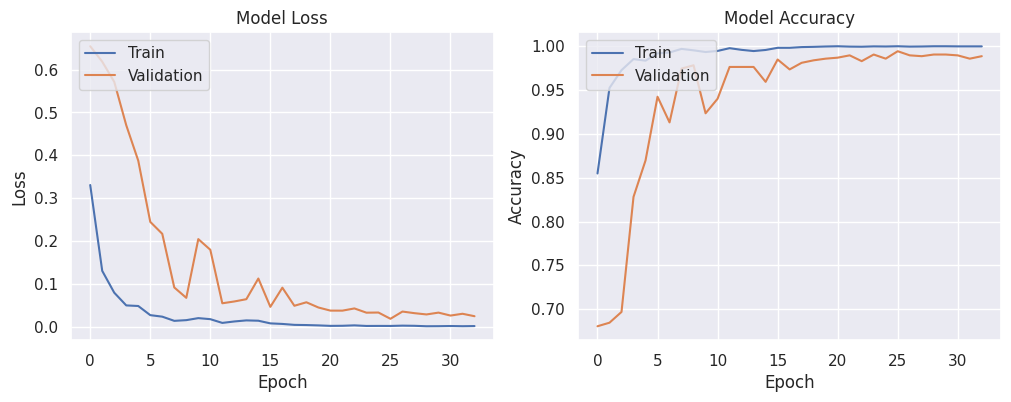

In [12]:
# plotting the validation and the training loss and accuracy in two plots, side by side
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper left')

plt.show()

### Testing the model

10/10 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


Test Accuracy: 0.9898819561551433
Test F1 Score: 0.9882327650356357
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       372
           1       0.99      0.99      0.99       814

    accuracy                           0.99      1186
   macro avg       0.99      0.99      0.99      1186
weighted avg       0.99      0.99      0.99      1186



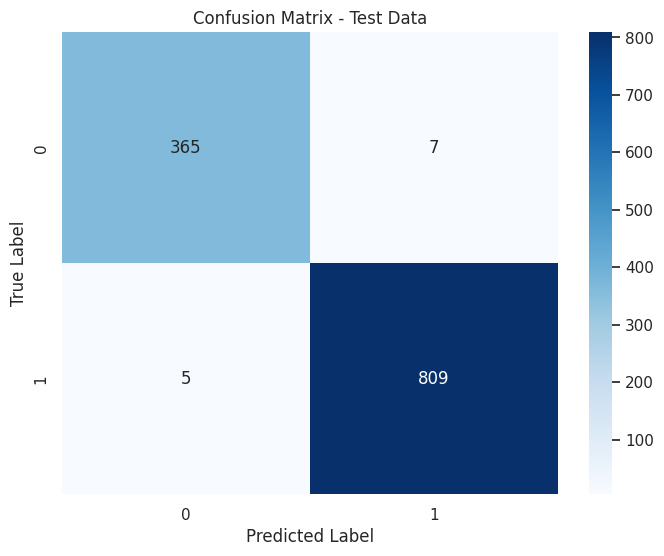

In [13]:
# get true labels from the test dataset
y_test_true = np.concatenate([y.numpy() for x, y in test_ds], axis = 0)

# predicting on the test dataset and rounding the results
test_predictions = model.predict(test_ds)
y_test_pred = np.round(test_predictions).astype(int).flatten()

# print the F1 score, accuracy, and classification report
test_f1 = f1_score(y_test_true, y_test_pred, average='macro')
test_accuracy = np.mean(y_test_true == y_test_pred)
print("Test Accuracy:", test_accuracy)
print("Test F1 Score:", test_f1)
print(classification_report(y_test_true, y_test_pred))

# compute and display the confusion matrix
test_conf_matrix = confusion_matrix(y_test_true, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Test Data")
plt.show()